Fetching 6 tickers from 2021-01-01 to today...


C:\Users\David\AppData\Local\Temp\ipykernel_29784\170026569.py:90: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")


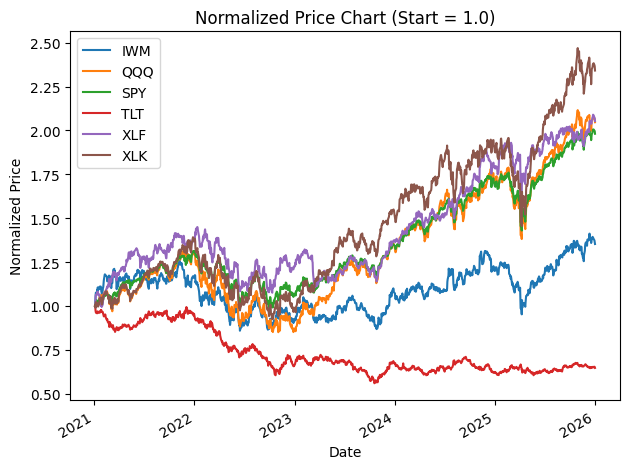

Displayed normalized price chart inline


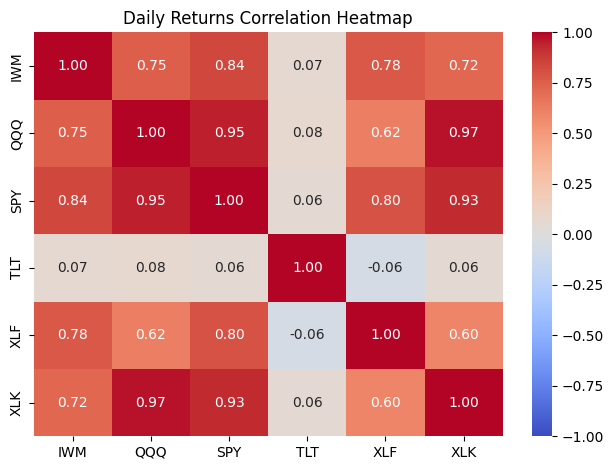

Displayed correlation heatmap inline
Highest Correlations (unique pairs):
QQQ  XLK    0.971744
     SPY    0.946503
SPY  XLK    0.927292
IWM  SPY    0.836540
SPY  XLF    0.797724
dtype: float64


In [1]:
import argparse
import os
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def get_price_data(tickers, start="2020-01-01", end=None):
    """Fetch adjusted close prices for given tickers using yfinance.

    Returns a DataFrame with tickers as columns and Date as index.
    """
    try:
        import yfinance as yf
    except ImportError:
        raise ImportError("yfinance is required to fetch stock data (pip install yfinance)")

    df = yf.download(tickers, start=start, end=end, auto_adjust=False, progress=False)

    # Prefer Adj Close, fall back to Close, fall back to full df
    if isinstance(df.columns, pd.MultiIndex) and "Adj Close" in df.columns.get_level_values(0):
        adj = df["Adj Close"]
    elif "Adj Close" in df.columns:
        adj = df[["Adj Close"]]
    else:
        adj = df["Close"] if "Close" in df.columns else df

    if isinstance(adj, pd.Series):
        adj = adj.to_frame(name=tickers[0])

    adj.columns = [str(c).upper() for c in adj.columns]
    adj = adj.dropna(how="all")
    return adj


def parse_tickers(s: str):
    if not s:
        return []
    return [t.strip().upper() for t in s.split(",") if t.strip()]


def main(argv=None):
    parser = argparse.ArgumentParser(description="Interactive correlation analysis with timestamped outputs")
    parser.add_argument("-t", "--tickers", help="Comma-separated tickers (e.g. AAPL,MSFT). If omitted, prompts interactively.")
    parser.add_argument("-s", "--start", default="2021-01-01", help="Start date (YYYY-MM-DD)")
    parser.add_argument("-e", "--end", default=None, help="End date (YYYY-MM-DD)")
    parser.add_argument("-o", "--outdir", default="outputs", help="Output directory for plots/CSVs")
    parser.add_argument("--save-csv", action="store_true", help="Also save the adjusted-close prices to CSV")
    parser.add_argument("--display", action="store_true", help="Display charts inline instead of saving (useful in notebooks)")

    # Detect if running in a Jupyter kernel
    try:
        from IPython import get_ipython
        in_ipynb = get_ipython() is not None
    except Exception:
        in_ipynb = False

    # In notebooks, the kernel injects extra argv which can confuse argparse.
    if argv is None:
        args, _ = parser.parse_known_args()
        # default to display in interactive notebook unless explicitly overridden
        if in_ipynb and not args.display:
            args.display = True
    else:
        args = parser.parse_args(argv)

    if args.tickers:
        tickers = parse_tickers(args.tickers)
    else:
        default = "SPY,QQQ,IWM,XLK,XLF,TLT"
        user = input(f"Enter tickers separated by comma (leave blank for defaults: {default}): ").strip()
        tickers = parse_tickers(user) if user else parse_tickers(default)

    if not tickers:
        print("No tickers specified; exiting.")
        return

    os.makedirs(args.outdir, exist_ok=True)

    print(f"Fetching {len(tickers)} tickers from {args.start} to {args.end or 'today'}...")
    prices = get_price_data(tickers, start=args.start, end=args.end)

    if prices is None or prices.empty:
        print("No data returned for the requested tickers/date range; exiting.")
        return

    # Optionally save adjusted close CSV
    ts = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")
    tickers_part = "_".join(tickers[:5]) + ("_more" if len(tickers) > 5 else "")
    if args.save_csv:
        csv_path = os.path.join(args.outdir, f"prices_{ts}_{tickers_part}_adj_close.csv")
        prices.to_csv(csv_path, index_label="Date")
        print(f"Saved adjusted close CSV to {csv_path}")

    # Compute returns and correlation
    returns = prices.pct_change().dropna()
    corr = returns.corr()

    # Robust normalization: drop empty columns and normalize by each column's first valid value
    valid_cols = [c for c in prices.columns if not prices[c].dropna().empty]
    if len(valid_cols) != len(prices.columns):
        dropped = sorted(list(set(prices.columns) - set(valid_cols)))
        print("Dropping columns with no data:", dropped)
        prices = prices[valid_cols]
        returns = prices.pct_change().dropna()
        corr = returns.corr()

    if prices.empty:
        print("No price data available after dropping empty columns; skipping plots.")
        return

    first_vals = prices.apply(lambda col: col.dropna().iloc[0])
    normalized = prices.divide(first_vals, axis=1)

    # Drop columns or rows that are completely empty after normalization
    normalized = normalized.dropna(axis=1, how="all").dropna(how="all")

    # Replace inf values with NaN and check if any finite numeric data remains
    normalized = normalized.replace([np.inf, -np.inf], np.nan)

    # --------------------------
    # Plot 1: Normalized prices
    # --------------------------
    if not normalized.notna().any().any():
        print("No finite numeric data to plot after normalization; skipping normalized chart.")
    else:
        fig, ax = plt.subplots()
        normalized.plot(ax=ax)
        ax.set_title("Normalized Price Chart (Start = 1.0)")
        ax.set_xlabel("Date")
        ax.set_ylabel("Normalized Price")
        ax.tick_params(axis="x", rotation=30)
        fig.tight_layout()

        if args.display:
            plt.show()
            print("Displayed normalized price chart inline")
        else:
            norm_path = os.path.join(args.outdir, f"normalized_price_chart_{ts}.png")
            fig.savefig(norm_path, dpi=200)
            print(f"Saved normalized price chart to {norm_path}")

        plt.close(fig)

    # --------------------------
    # Plot 2: Correlation heatmap
    # --------------------------
    if corr.empty or corr.shape[0] < 1:
        print("Correlation matrix is empty; skipping heatmap and pair listing.")
        return

    fig, ax = plt.subplots()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, ax=ax)
    ax.set_title("Daily Returns Correlation Heatmap")
    fig.tight_layout()

    if args.display:
        plt.show()
        print("Displayed correlation heatmap inline")
    else:
        corr_path = os.path.join(args.outdir, f"correlation_heatmap_{ts}.png")
        fig.savefig(corr_path, dpi=200)
        print(f"Saved correlation heatmap to {corr_path}")

    plt.close(fig)

    # Print top correlated pairs (unique pairs only)
    print("Highest Correlations (unique pairs):")
    upper = np.triu(np.ones_like(corr, dtype=bool), k=1)
    top_pairs = corr.where(upper).stack().sort_values(ascending=False)
    print(top_pairs.head(5))


if __name__ == "__main__":
    main()

Fetching 10 tickers from 2021-01-01 to today...


C:\Users\David\AppData\Local\Temp\ipykernel_29784\170026569.py:90: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")


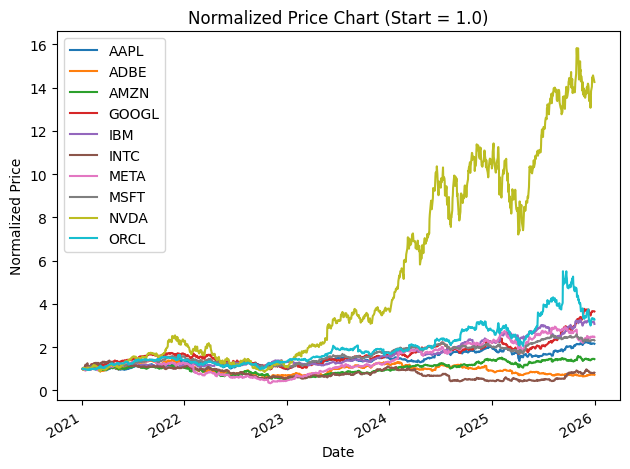

Displayed normalized price chart inline


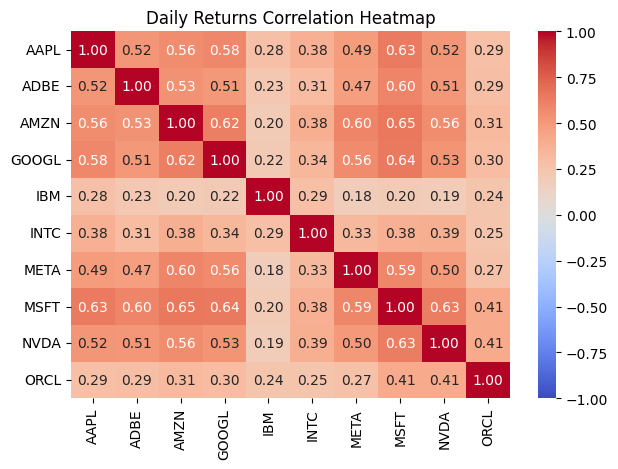

Displayed correlation heatmap inline
Highest Correlations (unique pairs):
AMZN   MSFT     0.654728
GOOGL  MSFT     0.644270
AAPL   MSFT     0.633958
MSFT   NVDA     0.630455
AMZN   GOOGL    0.619279
dtype: float64


In [2]:
import argparse
import os
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def get_price_data(tickers, start="2020-01-01", end=None):
    """Fetch adjusted close prices for given tickers using yfinance.

    Returns a DataFrame with tickers as columns and Date as index.
    """
    try:
        import yfinance as yf
    except ImportError:
        raise ImportError("yfinance is required to fetch stock data (pip install yfinance)")

    df = yf.download(tickers, start=start, end=end, auto_adjust=False, progress=False)

    # Prefer Adj Close, fall back to Close, fall back to full df
    if isinstance(df.columns, pd.MultiIndex) and "Adj Close" in df.columns.get_level_values(0):
        adj = df["Adj Close"]
    elif "Adj Close" in df.columns:
        adj = df[["Adj Close"]]
    else:
        adj = df["Close"] if "Close" in df.columns else df

    if isinstance(adj, pd.Series):
        adj = adj.to_frame(name=tickers[0])

    adj.columns = [str(c).upper() for c in adj.columns]
    adj = adj.dropna(how="all")
    return adj


def parse_tickers(s: str):
    if not s:
        return []
    return [t.strip().upper() for t in s.split(",") if t.strip()]


def main(argv=None):
    parser = argparse.ArgumentParser(description="Interactive correlation analysis with timestamped outputs")
    parser.add_argument("-t", "--tickers", help="Comma-separated tickers (e.g. AAPL,MSFT). If omitted, prompts interactively.")
    parser.add_argument("-s", "--start", default="2021-01-01", help="Start date (YYYY-MM-DD)")
    parser.add_argument("-e", "--end", default=None, help="End date (YYYY-MM-DD)")
    parser.add_argument("-o", "--outdir", default="outputs", help="Output directory for plots/CSVs")
    parser.add_argument("--save-csv", action="store_true", help="Also save the adjusted-close prices to CSV")
    parser.add_argument("--display", action="store_true", help="Display charts inline instead of saving (useful in notebooks)")

    # Detect if running in a Jupyter kernel
    try:
        from IPython import get_ipython
        in_ipynb = get_ipython() is not None
    except Exception:
        in_ipynb = False

    # In notebooks, the kernel injects extra argv which can confuse argparse.
    if argv is None:
        args, _ = parser.parse_known_args()
        # default to display in interactive notebook unless explicitly overridden
        if in_ipynb and not args.display:
            args.display = True
    else:
        args = parser.parse_args(argv)

    if args.tickers:
        tickers = parse_tickers(args.tickers)
    else:
        default = "SPY,QQQ,IWM,XLK,XLF,TLT"
        user = input(f"Enter tickers separated by comma (leave blank for defaults: {default}): ").strip()
        tickers = parse_tickers(user) if user else parse_tickers(default)

    if not tickers:
        print("No tickers specified; exiting.")
        return

    os.makedirs(args.outdir, exist_ok=True)

    print(f"Fetching {len(tickers)} tickers from {args.start} to {args.end or 'today'}...")
    prices = get_price_data(tickers, start=args.start, end=args.end)

    if prices is None or prices.empty:
        print("No data returned for the requested tickers/date range; exiting.")
        return

    # Optionally save adjusted close CSV
    ts = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")
    tickers_part = "_".join(tickers[:5]) + ("_more" if len(tickers) > 5 else "")
    if args.save_csv:
        csv_path = os.path.join(args.outdir, f"prices_{ts}_{tickers_part}_adj_close.csv")
        prices.to_csv(csv_path, index_label="Date")
        print(f"Saved adjusted close CSV to {csv_path}")

    # Compute returns and correlation
    returns = prices.pct_change().dropna()
    corr = returns.corr()

    # Robust normalization: drop empty columns and normalize by each column's first valid value
    valid_cols = [c for c in prices.columns if not prices[c].dropna().empty]
    if len(valid_cols) != len(prices.columns):
        dropped = sorted(list(set(prices.columns) - set(valid_cols)))
        print("Dropping columns with no data:", dropped)
        prices = prices[valid_cols]
        returns = prices.pct_change().dropna()
        corr = returns.corr()

    if prices.empty:
        print("No price data available after dropping empty columns; skipping plots.")
        return

    first_vals = prices.apply(lambda col: col.dropna().iloc[0])
    normalized = prices.divide(first_vals, axis=1)

    # Drop columns or rows that are completely empty after normalization
    normalized = normalized.dropna(axis=1, how="all").dropna(how="all")

    # Replace inf values with NaN and check if any finite numeric data remains
    normalized = normalized.replace([np.inf, -np.inf], np.nan)

    # --------------------------
    # Plot 1: Normalized prices
    # --------------------------
    if not normalized.notna().any().any():
        print("No finite numeric data to plot after normalization; skipping normalized chart.")
    else:
        fig, ax = plt.subplots()
        normalized.plot(ax=ax)
        ax.set_title("Normalized Price Chart (Start = 1.0)")
        ax.set_xlabel("Date")
        ax.set_ylabel("Normalized Price")
        ax.tick_params(axis="x", rotation=30)
        fig.tight_layout()

        if args.display:
            plt.show()
            print("Displayed normalized price chart inline")
        else:
            norm_path = os.path.join(args.outdir, f"normalized_price_chart_{ts}.png")
            fig.savefig(norm_path, dpi=200)
            print(f"Saved normalized price chart to {norm_path}")

        plt.close(fig)

    # --------------------------
    # Plot 2: Correlation heatmap
    # --------------------------
    if corr.empty or corr.shape[0] < 1:
        print("Correlation matrix is empty; skipping heatmap and pair listing.")
        return

    fig, ax = plt.subplots()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, ax=ax)
    ax.set_title("Daily Returns Correlation Heatmap")
    fig.tight_layout()

    if args.display:
        plt.show()
        print("Displayed correlation heatmap inline")
    else:
        corr_path = os.path.join(args.outdir, f"correlation_heatmap_{ts}.png")
        fig.savefig(corr_path, dpi=200)
        print(f"Saved correlation heatmap to {corr_path}")

    plt.close(fig)

    # Print top correlated pairs (unique pairs only)
    print("Highest Correlations (unique pairs):")
    upper = np.triu(np.ones_like(corr, dtype=bool), k=1)
    top_pairs = corr.where(upper).stack().sort_values(ascending=False)
    print(top_pairs.head(5))


if __name__ == "__main__":
    main()

Fetching 10 tickers from 2021-01-01 to today...


C:\Users\David\AppData\Local\Temp\ipykernel_29784\170026569.py:90: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")


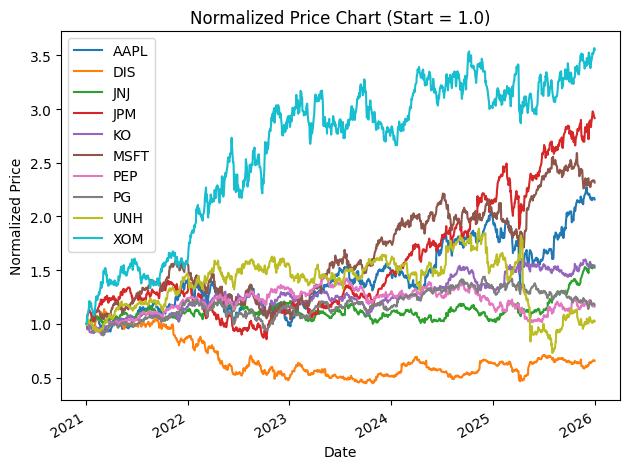

Displayed normalized price chart inline


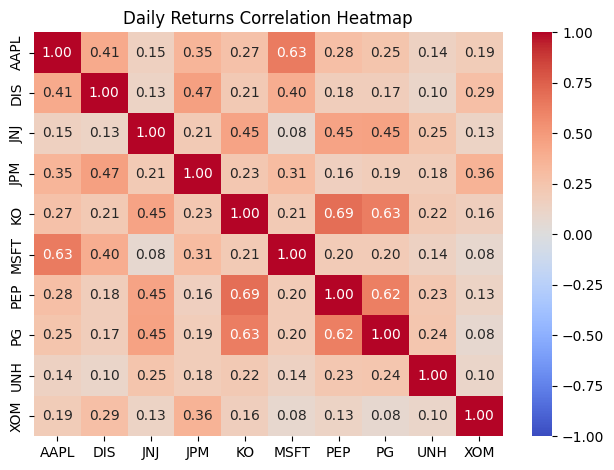

Displayed correlation heatmap inline
Highest Correlations (unique pairs):
KO    PEP     0.688746
AAPL  MSFT    0.633958
KO    PG      0.631255
PEP   PG      0.620372
DIS   JPM     0.465558
dtype: float64


In [3]:
import argparse
import os
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def get_price_data(tickers, start="2020-01-01", end=None):
    """Fetch adjusted close prices for given tickers using yfinance.

    Returns a DataFrame with tickers as columns and Date as index.
    """
    try:
        import yfinance as yf
    except ImportError:
        raise ImportError("yfinance is required to fetch stock data (pip install yfinance)")

    df = yf.download(tickers, start=start, end=end, auto_adjust=False, progress=False)

    # Prefer Adj Close, fall back to Close, fall back to full df
    if isinstance(df.columns, pd.MultiIndex) and "Adj Close" in df.columns.get_level_values(0):
        adj = df["Adj Close"]
    elif "Adj Close" in df.columns:
        adj = df[["Adj Close"]]
    else:
        adj = df["Close"] if "Close" in df.columns else df

    if isinstance(adj, pd.Series):
        adj = adj.to_frame(name=tickers[0])

    adj.columns = [str(c).upper() for c in adj.columns]
    adj = adj.dropna(how="all")
    return adj


def parse_tickers(s: str):
    if not s:
        return []
    return [t.strip().upper() for t in s.split(",") if t.strip()]


def main(argv=None):
    parser = argparse.ArgumentParser(description="Interactive correlation analysis with timestamped outputs")
    parser.add_argument("-t", "--tickers", help="Comma-separated tickers (e.g. AAPL,MSFT). If omitted, prompts interactively.")
    parser.add_argument("-s", "--start", default="2021-01-01", help="Start date (YYYY-MM-DD)")
    parser.add_argument("-e", "--end", default=None, help="End date (YYYY-MM-DD)")
    parser.add_argument("-o", "--outdir", default="outputs", help="Output directory for plots/CSVs")
    parser.add_argument("--save-csv", action="store_true", help="Also save the adjusted-close prices to CSV")
    parser.add_argument("--display", action="store_true", help="Display charts inline instead of saving (useful in notebooks)")

    # Detect if running in a Jupyter kernel
    try:
        from IPython import get_ipython
        in_ipynb = get_ipython() is not None
    except Exception:
        in_ipynb = False

    # In notebooks, the kernel injects extra argv which can confuse argparse.
    if argv is None:
        args, _ = parser.parse_known_args()
        # default to display in interactive notebook unless explicitly overridden
        if in_ipynb and not args.display:
            args.display = True
    else:
        args = parser.parse_args(argv)

    if args.tickers:
        tickers = parse_tickers(args.tickers)
    else:
        default = "SPY,QQQ,IWM,XLK,XLF,TLT"
        user = input(f"Enter tickers separated by comma (leave blank for defaults: {default}): ").strip()
        tickers = parse_tickers(user) if user else parse_tickers(default)

    if not tickers:
        print("No tickers specified; exiting.")
        return

    os.makedirs(args.outdir, exist_ok=True)

    print(f"Fetching {len(tickers)} tickers from {args.start} to {args.end or 'today'}...")
    prices = get_price_data(tickers, start=args.start, end=args.end)

    if prices is None or prices.empty:
        print("No data returned for the requested tickers/date range; exiting.")
        return

    # Optionally save adjusted close CSV
    ts = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")
    tickers_part = "_".join(tickers[:5]) + ("_more" if len(tickers) > 5 else "")
    if args.save_csv:
        csv_path = os.path.join(args.outdir, f"prices_{ts}_{tickers_part}_adj_close.csv")
        prices.to_csv(csv_path, index_label="Date")
        print(f"Saved adjusted close CSV to {csv_path}")

    # Compute returns and correlation
    returns = prices.pct_change().dropna()
    corr = returns.corr()

    # Robust normalization: drop empty columns and normalize by each column's first valid value
    valid_cols = [c for c in prices.columns if not prices[c].dropna().empty]
    if len(valid_cols) != len(prices.columns):
        dropped = sorted(list(set(prices.columns) - set(valid_cols)))
        print("Dropping columns with no data:", dropped)
        prices = prices[valid_cols]
        returns = prices.pct_change().dropna()
        corr = returns.corr()

    if prices.empty:
        print("No price data available after dropping empty columns; skipping plots.")
        return

    first_vals = prices.apply(lambda col: col.dropna().iloc[0])
    normalized = prices.divide(first_vals, axis=1)

    # Drop columns or rows that are completely empty after normalization
    normalized = normalized.dropna(axis=1, how="all").dropna(how="all")

    # Replace inf values with NaN and check if any finite numeric data remains
    normalized = normalized.replace([np.inf, -np.inf], np.nan)

    # --------------------------
    # Plot 1: Normalized prices
    # --------------------------
    if not normalized.notna().any().any():
        print("No finite numeric data to plot after normalization; skipping normalized chart.")
    else:
        fig, ax = plt.subplots()
        normalized.plot(ax=ax)
        ax.set_title("Normalized Price Chart (Start = 1.0)")
        ax.set_xlabel("Date")
        ax.set_ylabel("Normalized Price")
        ax.tick_params(axis="x", rotation=30)
        fig.tight_layout()

        if args.display:
            plt.show()
            print("Displayed normalized price chart inline")
        else:
            norm_path = os.path.join(args.outdir, f"normalized_price_chart_{ts}.png")
            fig.savefig(norm_path, dpi=200)
            print(f"Saved normalized price chart to {norm_path}")

        plt.close(fig)

    # --------------------------
    # Plot 2: Correlation heatmap
    # --------------------------
    if corr.empty or corr.shape[0] < 1:
        print("Correlation matrix is empty; skipping heatmap and pair listing.")
        return

    fig, ax = plt.subplots()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, ax=ax)
    ax.set_title("Daily Returns Correlation Heatmap")
    fig.tight_layout()

    if args.display:
        plt.show()
        print("Displayed correlation heatmap inline")
    else:
        corr_path = os.path.join(args.outdir, f"correlation_heatmap_{ts}.png")
        fig.savefig(corr_path, dpi=200)
        print(f"Saved correlation heatmap to {corr_path}")

    plt.close(fig)

    # Print top correlated pairs (unique pairs only)
    print("Highest Correlations (unique pairs):")
    upper = np.triu(np.ones_like(corr, dtype=bool), k=1)
    top_pairs = corr.where(upper).stack().sort_values(ascending=False)
    print(top_pairs.head(5))


if __name__ == "__main__":
    main()

Fetching 10 tickers from 2021-01-01 to today...


C:\Users\David\AppData\Local\Temp\ipykernel_29784\170026569.py:90: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")


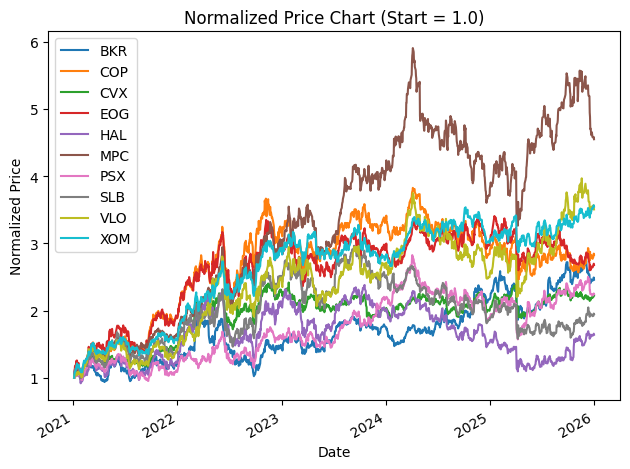

Displayed normalized price chart inline


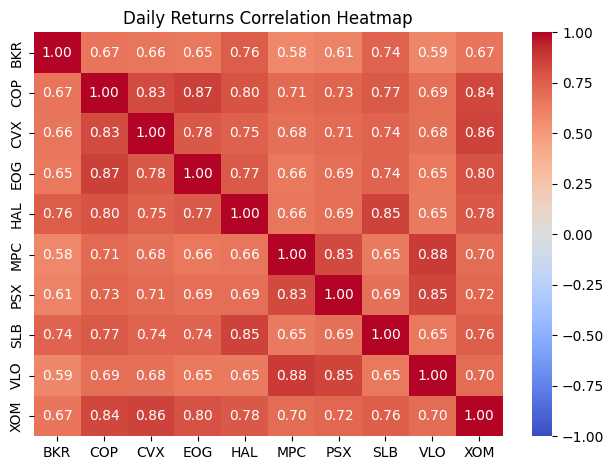

Displayed correlation heatmap inline
Highest Correlations (unique pairs):
MPC  VLO    0.876202
COP  EOG    0.866385
CVX  XOM    0.855120
HAL  SLB    0.854426
PSX  VLO    0.846720
dtype: float64


In [4]:
import argparse
import os
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def get_price_data(tickers, start="2020-01-01", end=None):
    """Fetch adjusted close prices for given tickers using yfinance.

    Returns a DataFrame with tickers as columns and Date as index.
    """
    try:
        import yfinance as yf
    except ImportError:
        raise ImportError("yfinance is required to fetch stock data (pip install yfinance)")

    df = yf.download(tickers, start=start, end=end, auto_adjust=False, progress=False)

    # Prefer Adj Close, fall back to Close, fall back to full df
    if isinstance(df.columns, pd.MultiIndex) and "Adj Close" in df.columns.get_level_values(0):
        adj = df["Adj Close"]
    elif "Adj Close" in df.columns:
        adj = df[["Adj Close"]]
    else:
        adj = df["Close"] if "Close" in df.columns else df

    if isinstance(adj, pd.Series):
        adj = adj.to_frame(name=tickers[0])

    adj.columns = [str(c).upper() for c in adj.columns]
    adj = adj.dropna(how="all")
    return adj


def parse_tickers(s: str):
    if not s:
        return []
    return [t.strip().upper() for t in s.split(",") if t.strip()]


def main(argv=None):
    parser = argparse.ArgumentParser(description="Interactive correlation analysis with timestamped outputs")
    parser.add_argument("-t", "--tickers", help="Comma-separated tickers (e.g. AAPL,MSFT). If omitted, prompts interactively.")
    parser.add_argument("-s", "--start", default="2021-01-01", help="Start date (YYYY-MM-DD)")
    parser.add_argument("-e", "--end", default=None, help="End date (YYYY-MM-DD)")
    parser.add_argument("-o", "--outdir", default="outputs", help="Output directory for plots/CSVs")
    parser.add_argument("--save-csv", action="store_true", help="Also save the adjusted-close prices to CSV")
    parser.add_argument("--display", action="store_true", help="Display charts inline instead of saving (useful in notebooks)")

    # Detect if running in a Jupyter kernel
    try:
        from IPython import get_ipython
        in_ipynb = get_ipython() is not None
    except Exception:
        in_ipynb = False

    # In notebooks, the kernel injects extra argv which can confuse argparse.
    if argv is None:
        args, _ = parser.parse_known_args()
        # default to display in interactive notebook unless explicitly overridden
        if in_ipynb and not args.display:
            args.display = True
    else:
        args = parser.parse_args(argv)

    if args.tickers:
        tickers = parse_tickers(args.tickers)
    else:
        default = "SPY,QQQ,IWM,XLK,XLF,TLT"
        user = input(f"Enter tickers separated by comma (leave blank for defaults: {default}): ").strip()
        tickers = parse_tickers(user) if user else parse_tickers(default)

    if not tickers:
        print("No tickers specified; exiting.")
        return

    os.makedirs(args.outdir, exist_ok=True)

    print(f"Fetching {len(tickers)} tickers from {args.start} to {args.end or 'today'}...")
    prices = get_price_data(tickers, start=args.start, end=args.end)

    if prices is None or prices.empty:
        print("No data returned for the requested tickers/date range; exiting.")
        return

    # Optionally save adjusted close CSV
    ts = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")
    tickers_part = "_".join(tickers[:5]) + ("_more" if len(tickers) > 5 else "")
    if args.save_csv:
        csv_path = os.path.join(args.outdir, f"prices_{ts}_{tickers_part}_adj_close.csv")
        prices.to_csv(csv_path, index_label="Date")
        print(f"Saved adjusted close CSV to {csv_path}")

    # Compute returns and correlation
    returns = prices.pct_change().dropna()
    corr = returns.corr()

    # Robust normalization: drop empty columns and normalize by each column's first valid value
    valid_cols = [c for c in prices.columns if not prices[c].dropna().empty]
    if len(valid_cols) != len(prices.columns):
        dropped = sorted(list(set(prices.columns) - set(valid_cols)))
        print("Dropping columns with no data:", dropped)
        prices = prices[valid_cols]
        returns = prices.pct_change().dropna()
        corr = returns.corr()

    if prices.empty:
        print("No price data available after dropping empty columns; skipping plots.")
        return

    first_vals = prices.apply(lambda col: col.dropna().iloc[0])
    normalized = prices.divide(first_vals, axis=1)

    # Drop columns or rows that are completely empty after normalization
    normalized = normalized.dropna(axis=1, how="all").dropna(how="all")

    # Replace inf values with NaN and check if any finite numeric data remains
    normalized = normalized.replace([np.inf, -np.inf], np.nan)

    # --------------------------
    # Plot 1: Normalized prices
    # --------------------------
    if not normalized.notna().any().any():
        print("No finite numeric data to plot after normalization; skipping normalized chart.")
    else:
        fig, ax = plt.subplots()
        normalized.plot(ax=ax)
        ax.set_title("Normalized Price Chart (Start = 1.0)")
        ax.set_xlabel("Date")
        ax.set_ylabel("Normalized Price")
        ax.tick_params(axis="x", rotation=30)
        fig.tight_layout()

        if args.display:
            plt.show()
            print("Displayed normalized price chart inline")
        else:
            norm_path = os.path.join(args.outdir, f"normalized_price_chart_{ts}.png")
            fig.savefig(norm_path, dpi=200)
            print(f"Saved normalized price chart to {norm_path}")

        plt.close(fig)

    # --------------------------
    # Plot 2: Correlation heatmap
    # --------------------------
    if corr.empty or corr.shape[0] < 1:
        print("Correlation matrix is empty; skipping heatmap and pair listing.")
        return

    fig, ax = plt.subplots()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, ax=ax)
    ax.set_title("Daily Returns Correlation Heatmap")
    fig.tight_layout()

    if args.display:
        plt.show()
        print("Displayed correlation heatmap inline")
    else:
        corr_path = os.path.join(args.outdir, f"correlation_heatmap_{ts}.png")
        fig.savefig(corr_path, dpi=200)
        print(f"Saved correlation heatmap to {corr_path}")

    plt.close(fig)

    # Print top correlated pairs (unique pairs only)
    print("Highest Correlations (unique pairs):")
    upper = np.triu(np.ones_like(corr, dtype=bool), k=1)
    top_pairs = corr.where(upper).stack().sort_values(ascending=False)
    print(top_pairs.head(5))


if __name__ == "__main__":
    main()

Fetching 10 tickers from 2021-01-01 to today...


C:\Users\David\AppData\Local\Temp\ipykernel_29784\170026569.py:90: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")


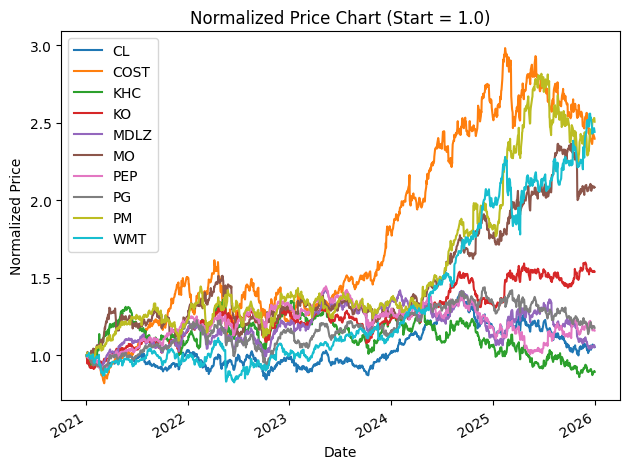

Displayed normalized price chart inline


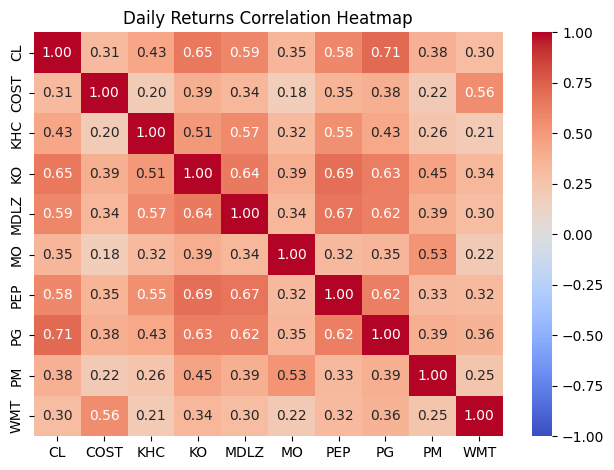

Displayed correlation heatmap inline
Highest Correlations (unique pairs):
CL    PG      0.713049
KO    PEP     0.688746
MDLZ  PEP     0.669319
CL    KO      0.648991
KO    MDLZ    0.642741
dtype: float64


In [5]:
import argparse
import os
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def get_price_data(tickers, start="2020-01-01", end=None):
    """Fetch adjusted close prices for given tickers using yfinance.

    Returns a DataFrame with tickers as columns and Date as index.
    """
    try:
        import yfinance as yf
    except ImportError:
        raise ImportError("yfinance is required to fetch stock data (pip install yfinance)")

    df = yf.download(tickers, start=start, end=end, auto_adjust=False, progress=False)

    # Prefer Adj Close, fall back to Close, fall back to full df
    if isinstance(df.columns, pd.MultiIndex) and "Adj Close" in df.columns.get_level_values(0):
        adj = df["Adj Close"]
    elif "Adj Close" in df.columns:
        adj = df[["Adj Close"]]
    else:
        adj = df["Close"] if "Close" in df.columns else df

    if isinstance(adj, pd.Series):
        adj = adj.to_frame(name=tickers[0])

    adj.columns = [str(c).upper() for c in adj.columns]
    adj = adj.dropna(how="all")
    return adj


def parse_tickers(s: str):
    if not s:
        return []
    return [t.strip().upper() for t in s.split(",") if t.strip()]


def main(argv=None):
    parser = argparse.ArgumentParser(description="Interactive correlation analysis with timestamped outputs")
    parser.add_argument("-t", "--tickers", help="Comma-separated tickers (e.g. AAPL,MSFT). If omitted, prompts interactively.")
    parser.add_argument("-s", "--start", default="2021-01-01", help="Start date (YYYY-MM-DD)")
    parser.add_argument("-e", "--end", default=None, help="End date (YYYY-MM-DD)")
    parser.add_argument("-o", "--outdir", default="outputs", help="Output directory for plots/CSVs")
    parser.add_argument("--save-csv", action="store_true", help="Also save the adjusted-close prices to CSV")
    parser.add_argument("--display", action="store_true", help="Display charts inline instead of saving (useful in notebooks)")

    # Detect if running in a Jupyter kernel
    try:
        from IPython import get_ipython
        in_ipynb = get_ipython() is not None
    except Exception:
        in_ipynb = False

    # In notebooks, the kernel injects extra argv which can confuse argparse.
    if argv is None:
        args, _ = parser.parse_known_args()
        # default to display in interactive notebook unless explicitly overridden
        if in_ipynb and not args.display:
            args.display = True
    else:
        args = parser.parse_args(argv)

    if args.tickers:
        tickers = parse_tickers(args.tickers)
    else:
        default = "SPY,QQQ,IWM,XLK,XLF,TLT"
        user = input(f"Enter tickers separated by comma (leave blank for defaults: {default}): ").strip()
        tickers = parse_tickers(user) if user else parse_tickers(default)

    if not tickers:
        print("No tickers specified; exiting.")
        return

    os.makedirs(args.outdir, exist_ok=True)

    print(f"Fetching {len(tickers)} tickers from {args.start} to {args.end or 'today'}...")
    prices = get_price_data(tickers, start=args.start, end=args.end)

    if prices is None or prices.empty:
        print("No data returned for the requested tickers/date range; exiting.")
        return

    # Optionally save adjusted close CSV
    ts = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")
    tickers_part = "_".join(tickers[:5]) + ("_more" if len(tickers) > 5 else "")
    if args.save_csv:
        csv_path = os.path.join(args.outdir, f"prices_{ts}_{tickers_part}_adj_close.csv")
        prices.to_csv(csv_path, index_label="Date")
        print(f"Saved adjusted close CSV to {csv_path}")

    # Compute returns and correlation
    returns = prices.pct_change().dropna()
    corr = returns.corr()

    # Robust normalization: drop empty columns and normalize by each column's first valid value
    valid_cols = [c for c in prices.columns if not prices[c].dropna().empty]
    if len(valid_cols) != len(prices.columns):
        dropped = sorted(list(set(prices.columns) - set(valid_cols)))
        print("Dropping columns with no data:", dropped)
        prices = prices[valid_cols]
        returns = prices.pct_change().dropna()
        corr = returns.corr()

    if prices.empty:
        print("No price data available after dropping empty columns; skipping plots.")
        return

    first_vals = prices.apply(lambda col: col.dropna().iloc[0])
    normalized = prices.divide(first_vals, axis=1)

    # Drop columns or rows that are completely empty after normalization
    normalized = normalized.dropna(axis=1, how="all").dropna(how="all")

    # Replace inf values with NaN and check if any finite numeric data remains
    normalized = normalized.replace([np.inf, -np.inf], np.nan)

    # --------------------------
    # Plot 1: Normalized prices
    # --------------------------
    if not normalized.notna().any().any():
        print("No finite numeric data to plot after normalization; skipping normalized chart.")
    else:
        fig, ax = plt.subplots()
        normalized.plot(ax=ax)
        ax.set_title("Normalized Price Chart (Start = 1.0)")
        ax.set_xlabel("Date")
        ax.set_ylabel("Normalized Price")
        ax.tick_params(axis="x", rotation=30)
        fig.tight_layout()

        if args.display:
            plt.show()
            print("Displayed normalized price chart inline")
        else:
            norm_path = os.path.join(args.outdir, f"normalized_price_chart_{ts}.png")
            fig.savefig(norm_path, dpi=200)
            print(f"Saved normalized price chart to {norm_path}")

        plt.close(fig)

    # --------------------------
    # Plot 2: Correlation heatmap
    # --------------------------
    if corr.empty or corr.shape[0] < 1:
        print("Correlation matrix is empty; skipping heatmap and pair listing.")
        return

    fig, ax = plt.subplots()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, ax=ax)
    ax.set_title("Daily Returns Correlation Heatmap")
    fig.tight_layout()

    if args.display:
        plt.show()
        print("Displayed correlation heatmap inline")
    else:
        corr_path = os.path.join(args.outdir, f"correlation_heatmap_{ts}.png")
        fig.savefig(corr_path, dpi=200)
        print(f"Saved correlation heatmap to {corr_path}")

    plt.close(fig)

    # Print top correlated pairs (unique pairs only)
    print("Highest Correlations (unique pairs):")
    upper = np.triu(np.ones_like(corr, dtype=bool), k=1)
    top_pairs = corr.where(upper).stack().sort_values(ascending=False)
    print(top_pairs.head(5))


if __name__ == "__main__":
    main()